#Import Libraries

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

# Image Preprocessing

In [43]:
image_file_name = '/content/image.jpg'
image = tf.io.read_file(image_file_name)
image = tf.io.decode_jpeg(image, channels=3)

mask_file_name = '/content/mask.jpg'
mask = tf.io.read_file(mask_file_name)
mask = tf.io.decode_image(mask, channels=1, expand_animations=False)
# Converting mask to a 2D array (hxwx1, only 1 output class (water body))
mask = tf.reshape(mask, shape= (mask.get_shape()[0], mask.get_shape()[1]))


In [44]:
print("Mask Tensor Shape is ",mask.get_shape())
print("Image Tensor Shape is ",image.get_shape())


Mask Tensor Shape is  (659, 658)
Image Tensor Shape is  (659, 658, 3)


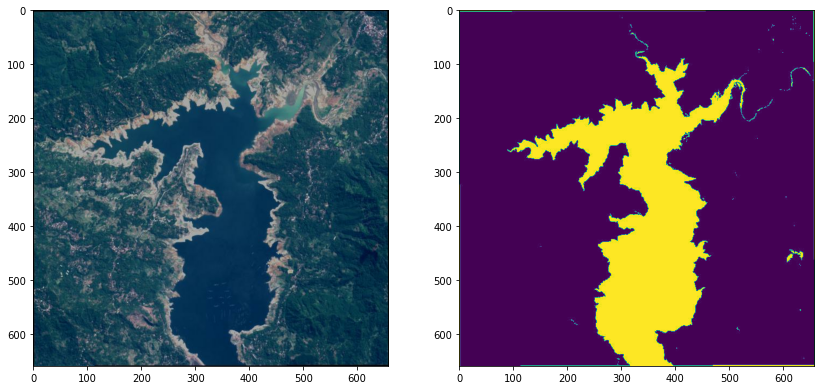

In [45]:
fig, ax = plt.subplots(1, 2, figsize = (14, 7))
ax[0].imshow(image)
ax[1].imshow(mask)

# U-Net Model

In [102]:
def conv_block(inputs, n_filters, max_Pooling = True):
  conv = keras.layers.Conv2D(n_filters, kernel_size = 3, activation= 'relu', padding='same', kernel_initializer='he_normal')(inputs)
  conv = keras.layers.Conv2D(n_filters, kernel_size = 3, activation= 'relu', padding='same', kernel_initializer='he_normal')(conv)
  
  if max_Pooling:
    down_output = keras.layers.MaxPooling2D(pool_size=(2,2))(conv)
  else:
    down_output = conv
  skip_output = conv

  return down_output, skip_output




In [103]:
def up_block(up_input, skip_input, n_filters):
  up = keras.layers.Conv2DTranspose(n_filters, kernel_size=3, strides = (2,2), padding = 'same')(up_input)
  sum = keras.layers.concatenate([up, skip_input], axis= 3)

  conv = keras.layers.Conv2D(n_filters, kernel_size = 3, activation= 'relu', padding='same', kernel_initializer='he_normal')(sum)
  conv = keras.layers.Conv2D(n_filters, kernel_size = 3, activation= 'relu', padding='same', kernel_initializer='he_normal')(conv)

  return conv

In [104]:
def unet_model(input_size , n_filters, n_classes):
  inputs = keras.layers.Input(input_size)

  down_block_1 = conv_block(inputs, n_filters, max_Pooling=True)
  down_block_2 = conv_block(down_block_1[0], n_filters*2, max_Pooling=True)
  down_block_3 = conv_block(down_block_2[0], n_filters*4, max_Pooling=True)
  down_block_4 = conv_block(down_block_3[0], n_filters*8, max_Pooling=True)
  down_block_5 = conv_block(down_block_4[0], n_filters*16, max_Pooling=False)

  up_block_6 = up_block(down_block_5[0], down_block_4[1], n_filters*8)
  up_block_7 = up_block(up_block_6, down_block_3[1], n_filters*4)
  up_block_8 = up_block(up_block_7, down_block_2[1], n_filters*2)
  up_block_9 = up_block(up_block_8, down_block_1[1], n_filters)

  conv_9 = keras.layers.Conv2D(n_filters, kernel_size = 3, activation= 'relu', padding='same', kernel_initializer='he_normal')(up_block_9)

  conv_10 = keras.layers.Conv2D(n_classes, kernel_size = 1, padding = 'same')(conv_9)

  model = keras.Model(inputs = inputs, outputs= conv_10)

  return model

In [105]:
model = unet_model(input_size=(96, 128, 3), n_filters= 32, n_classes= 1)